# Import required libraries

In [1]:
from os.path import exists

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_friedman1
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, SGD, RMSprop

# Set up google drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_DIR = "/content/drive/My Drive/networks_data/hw1/" 

# Generate a large tabular dataset with 10 features, 1 regression target, 150 000 rows

In [4]:
# Dataset is already generated and saved on Google drive
X = np.load(DATA_DIR + "X.npy")
y = np.load(DATA_DIR + "y.npy")


In [5]:
print("Shape of X: ",X.shape,"Shape of y: ", y.shape)
print("X:", X, sep="\n")
print("y:", y, sep="\n")
print(f"Min x {np.min(X)}, max x {np.max(X)}")
print(f"Min y {np.min(y)}, max y {np.max(y)}")

Shape of X:  (150000, 10) Shape of y:  (150000,)
X:
[[0.82048756 0.12659985 0.05013391 ... 0.22044959 0.78821311 0.63110435]
 [0.20826671 0.31156318 0.27545451 ... 0.21722712 0.14182637 0.56848439]
 [0.67442761 0.84242855 0.48364812 ... 0.83708568 0.95747409 0.63802075]
 ...
 [0.89810295 0.77488    0.00173942 ... 0.14400551 0.296422   0.47490449]
 [0.8125191  0.38257582 0.02230259 ... 0.43286972 0.21044137 0.95173476]
 [0.40942565 0.38725282 0.72804597 ... 0.45875636 0.87845899 0.24988657]]
y:
[18.80134402  8.12692727 19.73925284 ... 17.03143336 14.5655544
  9.22327039]
Min x 9.85033683620351e-07, max x 0.9999996429532808
Min y 0.3149994006024924, max y 29.47009003815792


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the target using Linear Regression (LR).

In [7]:
LR = LinearRegression()
LR_history = LR.fit(X, y)
print("Train score:", LR.score(X_train, y_train))
print("Test score:", LR.score(X_test, y_test))

Train score: 0.7531244329526628
Test score: 0.7528171734156689


In [8]:
y_pred = LR.predict(X_test)
LR_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
LR_df

,True,Predicted
0,13.482332,13.765096
1,18.516545,20.041859
2,15.795384,13.275280
3,12.870252,13.208754
4,15.509118,14.487531
...,...,...
29995,16.967015,15.241504
29996,15.199145,15.216874
29997,14.345414,14.371505
29998,19.008525,17.438263


Train DNN

In [9]:
class DNN1(nn.Module):
    def __init__(self):
        super(DNN1, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

class DNN2(nn.Module):
    def __init__(self):
        super(DNN2, self).__init__()
        layers = [nn.Linear(10, 30), nn.ReLU()]

        for i in range(5):
            layers += [nn.Linear(30, 30), nn.ReLU()]

        layers += [nn.Linear(30, 1)]

        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


class DNN3(nn.Module):
    def __init__(self):
        super(DNN3, self).__init__()
        layers = [nn.Linear(10, 30), nn.ReLU()]

        for i in range(25):
            layers += [nn.Linear(30, 30), nn.ReLU()]

        layers += [nn.Linear(30, 1)]

        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


In [10]:
def record_metrics(epoch, y_train, y_train_pred, y_test, y_test_pred):

    return pd.DataFrame(
        {
            "R2 train": r2_score(y_train, y_train_pred), "R2 test": r2_score(y_test, y_test_pred), 
            "MSE train": mean_squared_error(y_train, y_train_pred), "MSE test": mean_squared_error(y_test, y_test_pred),
            "MAE train": mean_absolute_error(y_train, y_train_pred), "MAE test": mean_absolute_error(y_test, y_test_pred), 
            "MAPE train": mean_absolute_percentage_error(y_train, y_train_pred), "MAPE test": mean_absolute_percentage_error(y_test, y_test_pred)  
        }, index=[epoch])

In [11]:
baseline = record_metrics("LR", y_train, LR.predict(X_train), y_test, LR.predict(X_test))

In [12]:
x_train_tensor = Tensor(X_train).to("cuda")
y_train_tensor = Tensor(y_train).to("cuda")
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

x_test_tensor = Tensor(X_test).to("cuda")
y_test_tensor = Tensor(y_test).to("cuda")
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)


In [13]:
def test_less(model, criterion, test_dataset):
    dataloader = DataLoader(test_dataset)
    num_batches = len(dataloader)

    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += criterion(pred, y).item()

    return test_loss / num_batches

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
result_histories = {}
result_models = {}
# history = pd.DataFrame(columns=["Loss train", "Loss test"])
epochs = 4
# DNN1, 
for dnn in [DNN3]:
  # SGD, RMSprop,
  for opt in [ Adam]:
    for learning_rate in [0.001]:
      try:    
        name = f"{dnn.__name__} {opt.__name__}-{learning_rate}-{epochs}-epoch"
        print(f"Train {name} model")
        criterion = nn.MSELoss()
        model = dnn().to("cuda")
        optimizer = opt(model.parameters(), lr=learning_rate)
        dataloader = DataLoader(train_dataset)
        num_batches = len(dataloader)
        history = pd.DataFrame(columns=["Loss train", "Loss test"])
        for epoch in range(epochs):  # loop over the dataset multiple times
            print(f"Epoch {epoch + 1}:")

            epoch_loss = 0.0
            running_loss = 0.0
            for i, data in enumerate(dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                epoch_loss += loss.item()
                if i % 5000 == 4999:    # print every 5000 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5000:.3f}')
                    running_loss = 0.0

            x_train, y_train = train_dataset.tensors
            x_test, y_test = test_dataset.tensors
        
            y_train_pred = model(x_train)
            y_test_pred = model(x_test)

            history = pd.concat([history, record_metrics(epoch + 1, y_train.cpu().detach().numpy(),
                                                   y_train_pred.cpu().detach().numpy(), y_test.cpu().detach().numpy(),
                                                   y_test_pred.cpu().detach().numpy())])

            epoch_loss /= num_batches

            print(f"[{epoch + 1}/{epochs}] mean epoch loss: {epoch_loss:.3f}")

            history.at[epoch + 1, "Loss train"] = epoch_loss
            history.at[epoch + 1, "Loss test"] = test_less(model, criterion, test_dataset)

       
        torch.save(model.state_dict(), f"{DATA_DIR}{name}.pth")
        print(f"Saved PyTorch Model State to {DATA_DIR}{name}.pth")

        history.to_csv(f"{DATA_DIR}{name}-history.csv")
        print(f"Saved PyTorch Model history to {DATA_DIR}{name}-history.csv")

        result_histories[name] = history
        result_models[name] = model
      except Exception as e:
        print(e)
print('Finished Training')

Train DNN3 Adam-0.001-4-epoch model
Epoch 1:


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,  5000] loss: 13.563
[1, 10000] loss: 5.460
[1, 15000] loss: 2.892
[1, 20000] loss: 1.962
[1, 25000] loss: 1.479
[1, 30000] loss: 1.199
[1, 35000] loss: 1.035
[1, 40000] loss: 0.777
[1, 45000] loss: 0.655
[1, 50000] loss: 0.664
[1, 55000] loss: 0.564
[1, 60000] loss: 0.525
[1, 65000] loss: 0.435
[1, 70000] loss: 0.456
[1, 75000] loss: 0.419
[1, 80000] loss: 0.360
[1, 85000] loss: 0.349
[1, 90000] loss: 0.348
[1, 95000] loss: 0.341
[1, 100000] loss: 0.291
[1, 105000] loss: 0.329
[1, 110000] loss: 0.287
[1, 115000] loss: 0.270
[1, 120000] loss: 0.279
[1/4] mean epoch loss: 1.456


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2:
[2,  5000] loss: 0.252
[2, 10000] loss: 0.250
[2, 15000] loss: 0.256
[2, 20000] loss: 0.258
[2, 25000] loss: 0.237
[2, 30000] loss: 0.250
[2, 35000] loss: 0.227
[2, 40000] loss: 0.205
[2, 45000] loss: 0.234
[2, 50000] loss: 0.209
[2, 55000] loss: 0.213
[2, 60000] loss: 0.228
[2, 65000] loss: 0.207
[2, 70000] loss: 0.187
[2, 75000] loss: 0.181
[2, 80000] loss: 0.180
[2, 85000] loss: 0.192
[2, 90000] loss: 0.179
[2, 95000] loss: 0.184
[2, 100000] loss: 0.176
[2, 105000] loss: 0.187
[2, 110000] loss: 0.168
[2, 115000] loss: 0.152
[2, 120000] loss: 0.160
[2/4] mean epoch loss: 0.207


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3:
[3,  5000] loss: 0.162
[3, 10000] loss: 0.161
[3, 15000] loss: 0.167
[3, 20000] loss: 0.166
[3, 25000] loss: 0.157
[3, 30000] loss: 0.159
[3, 35000] loss: 0.157
[3, 40000] loss: 0.134
[3, 45000] loss: 0.144
[3, 50000] loss: 0.159
[3, 55000] loss: 0.149
[3, 60000] loss: 0.138
[3, 65000] loss: 0.148
[3, 70000] loss: 0.143
[3, 75000] loss: 0.129
[3, 80000] loss: 0.150
[3, 85000] loss: 0.130
[3, 90000] loss: 0.123
[3, 95000] loss: 0.128
[3, 100000] loss: 0.133
[3, 105000] loss: 0.123
[3, 110000] loss: 0.130
[3, 115000] loss: 0.121
[3, 120000] loss: 0.122
[3/4] mean epoch loss: 0.143


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4:
[4,  5000] loss: 0.145
[4, 10000] loss: 0.113
[4, 15000] loss: 0.122
[4, 20000] loss: 0.146
[4, 25000] loss: 0.114
[4, 30000] loss: 0.117
[4, 35000] loss: 0.119
[4, 40000] loss: 0.113
[4, 45000] loss: 0.108
[4, 50000] loss: 0.126
[4, 55000] loss: 0.116
[4, 60000] loss: 0.109
[4, 65000] loss: 0.120
[4, 70000] loss: 0.109
[4, 75000] loss: 0.106
[4, 80000] loss: 0.108
[4, 85000] loss: 0.109
[4, 90000] loss: 0.105
[4, 95000] loss: 0.107
[4, 100000] loss: 0.105
[4, 105000] loss: 0.104
[4, 110000] loss: 0.111
[4, 115000] loss: 0.102
[4, 120000] loss: 0.107
[4/4] mean epoch loss: 0.114


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Saved PyTorch Model State to /content/drive/My Drive/networks_data/hw1/DNN3 Adam-0.001-4-epoch.pth
Saved PyTorch Model history to /content/drive/My Drive/networks_data/hw1/DNN3 Adam-0.001-4-epoch-history.csv
Finished Training


In [15]:
def load_model_and_history(dnn, opt, learning_rate, epochs):
    name = f"{dnn.__name__} {opt.__name__}-{learning_rate}-{epochs}-epoch"

    if exists(f"{DATA_DIR}{name}.pth"):
        model = dnn()
        model.load_state_dict(torch.load(f"{DATA_DIR}{name}.pth"))
        model.eval()
        print(f"Load PyTorch Model State from {name}.pth")
    else:
        model = None
        print(f"Can't load Model State from {name}.pth, file not exists!")

    if exists(f"{DATA_DIR}{name}-history.csv"):
        history = pd.read_csv(f"{DATA_DIR}{name}-history.csv", index_col="Unnamed: 0")
        print(f"Load PyTorch Model history from {DATA_DIR}{name}-history.csv")
    else:
        history = None
        print(f"Can't load Model history from {name}.pth, file not exists!")

    return name, history, model

In [16]:

result_histories = {}
result_models = {}
total_acc = baseline.copy()

epochs = 4
for dnn in [DNN1, DNN2, DNN3]:
    for optimizer in [SGD, RMSprop, Adam]:
        for lr in [0.1, 0.01, 0.001]:
            name, history, model = load_model_and_history(dnn, optimizer, lr, epochs)
            if history is not None and model is not None:
                result_histories[name] = history
                result_models[name] = model

                result = history.loc[epochs - 1]
                result.name = name
                total_acc = total_acc.append(result)

Can't load Model State from DNN1 SGD-0.1-4-epoch.pth, file not exists!
Can't load Model history from DNN1 SGD-0.1-4-epoch.pth, file not exists!
Load PyTorch Model State from DNN1 SGD-0.01-4-epoch.pth
Load PyTorch Model history from /content/drive/My Drive/networks_data/hw1/DNN1 SGD-0.01-4-epoch-history.csv
Load PyTorch Model State from DNN1 SGD-0.001-4-epoch.pth
Load PyTorch Model history from /content/drive/My Drive/networks_data/hw1/DNN1 SGD-0.001-4-epoch-history.csv
Load PyTorch Model State from DNN1 RMSprop-0.1-4-epoch.pth
Load PyTorch Model history from /content/drive/My Drive/networks_data/hw1/DNN1 RMSprop-0.1-4-epoch-history.csv
Load PyTorch Model State from DNN1 RMSprop-0.01-4-epoch.pth
Load PyTorch Model history from /content/drive/My Drive/networks_data/hw1/DNN1 RMSprop-0.01-4-epoch-history.csv
Load PyTorch Model State from DNN1 RMSprop-0.001-4-epoch.pth
Load PyTorch Model history from /content/drive/My Drive/networks_data/hw1/DNN1 RMSprop-0.001-4-epoch-history.csv
Load PyTor

In [17]:
import matplotlib.pyplot as plt
def plot_learning_curves(result, baseline):
    plt.plot(result['R2 train'])
    plt.plot(result['R2 test'])
    plt.title('model R2')
    plt.ylabel('R2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(result['MSE train'])
    plt.plot(result['MSE test'])
    plt.title('model MSE')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

DNN1 SGD-0.01-4-epoch


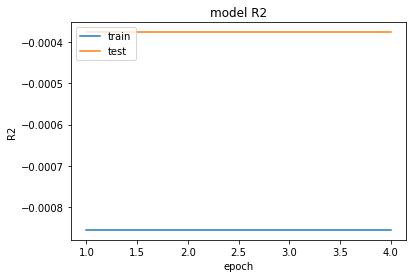

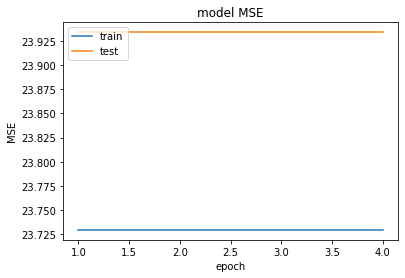

DNN1 SGD-0.001-4-epoch


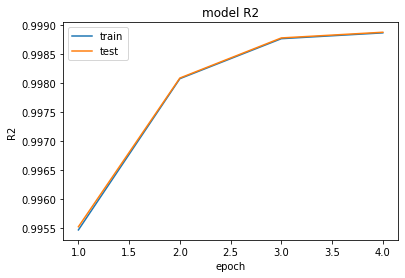

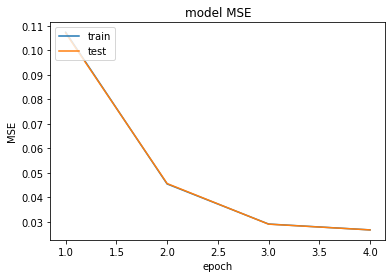

DNN1 RMSprop-0.1-4-epoch


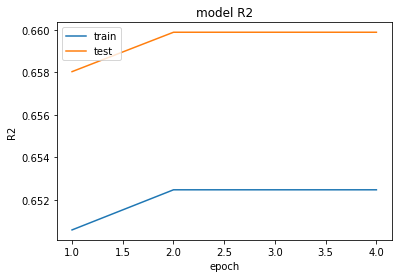

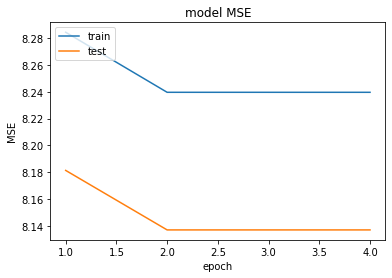

DNN1 RMSprop-0.01-4-epoch


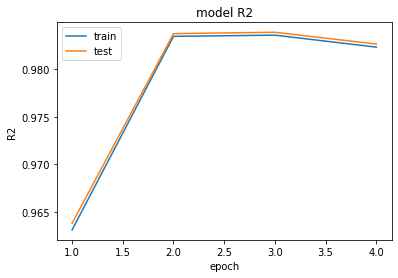

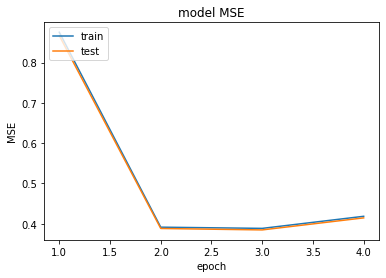

DNN1 RMSprop-0.001-4-epoch


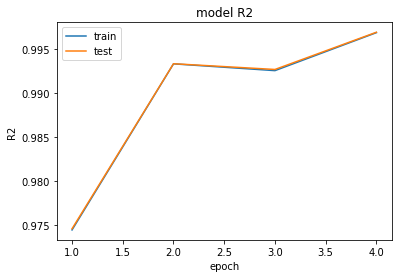

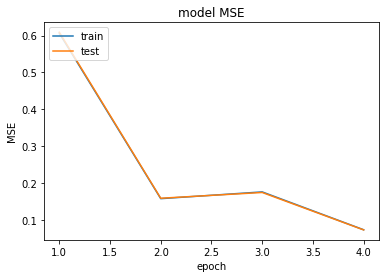

DNN1 Adam-0.1-4-epoch


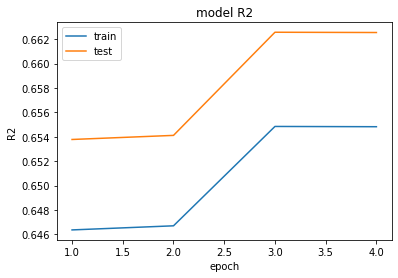

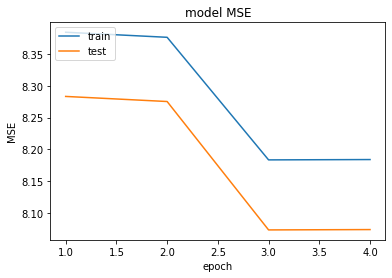

DNN1 Adam-0.01-4-epoch


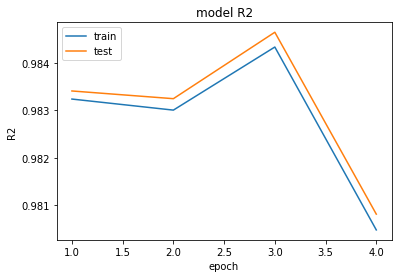

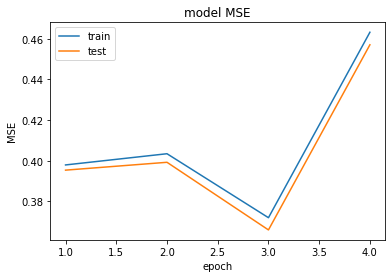

DNN1 Adam-0.001-4-epoch


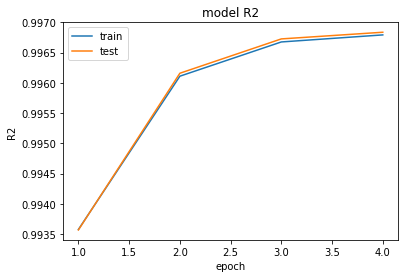

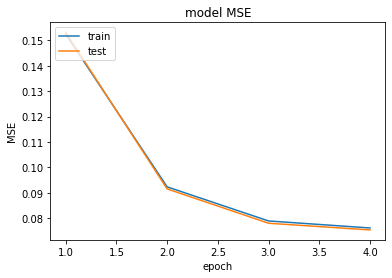

DNN2 SGD-0.01-4-epoch


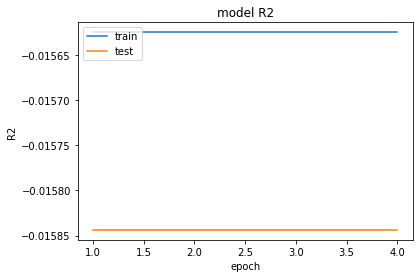

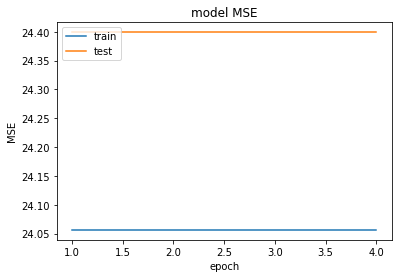

DNN2 SGD-0.001-4-epoch


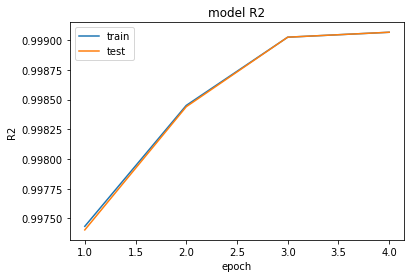

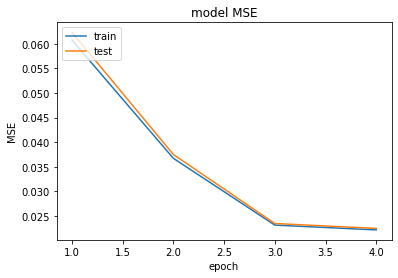

DNN2 RMSprop-0.1-4-epoch


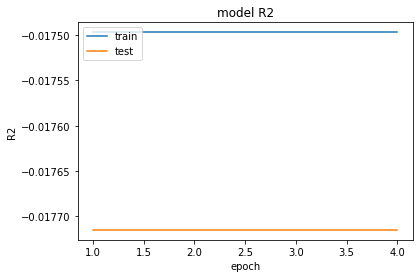

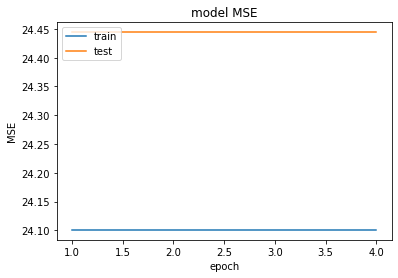

DNN2 RMSprop-0.01-4-epoch


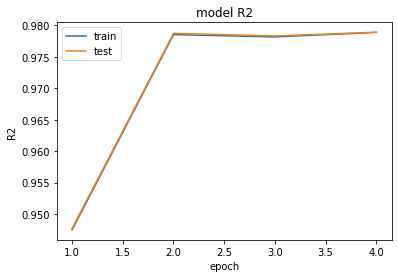

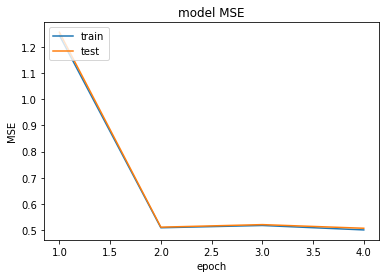

DNN2 RMSprop-0.001-4-epoch


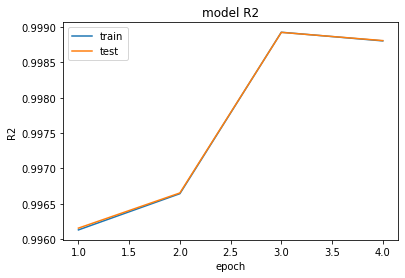

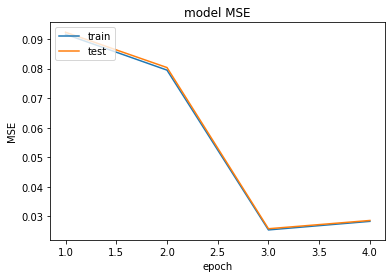

DNN2 Adam-0.1-4-epoch


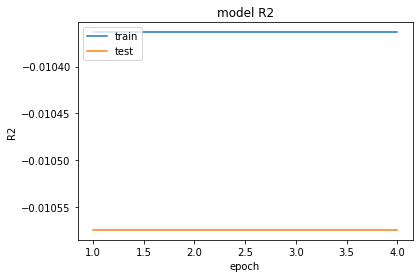

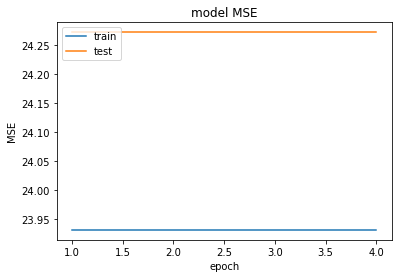

DNN2 Adam-0.01-4-epoch


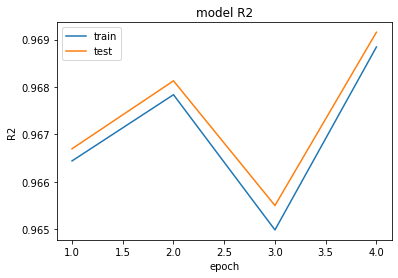

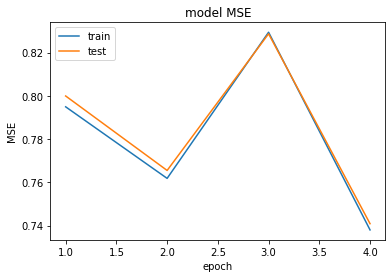

DNN2 Adam-0.001-4-epoch


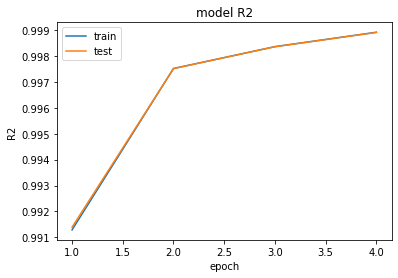

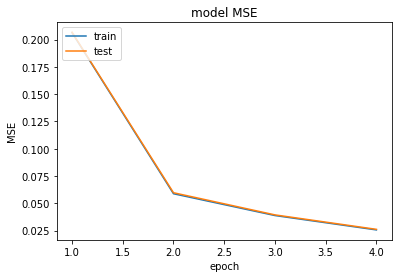

DNN3 SGD-0.01-4-epoch


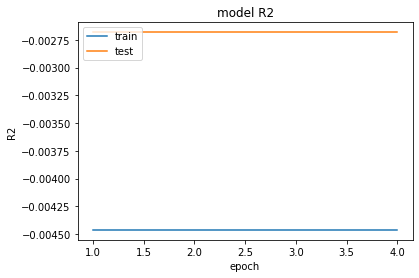

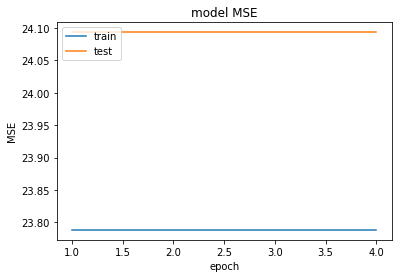

DNN3 SGD-0.001-4-epoch


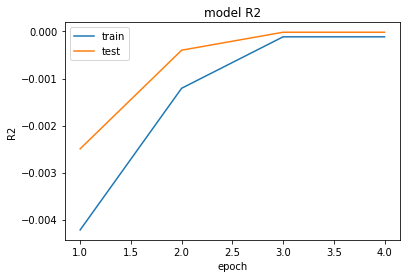

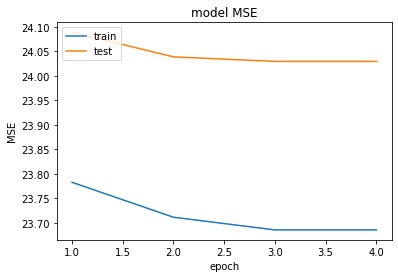

DNN3 RMSprop-0.1-4-epoch


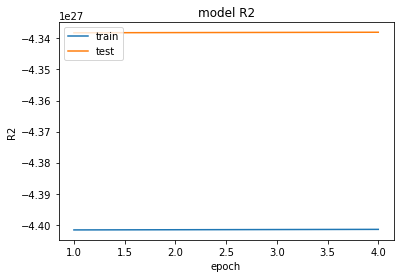

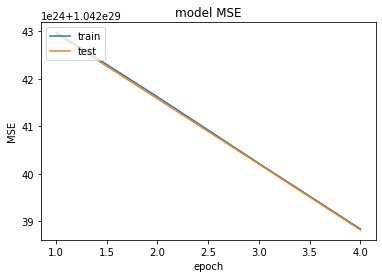

DNN3 Adam-0.1-4-epoch


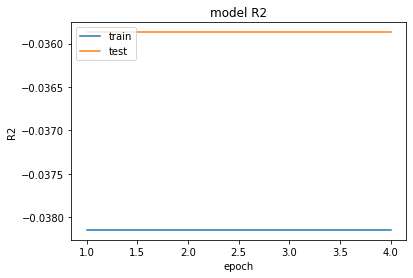

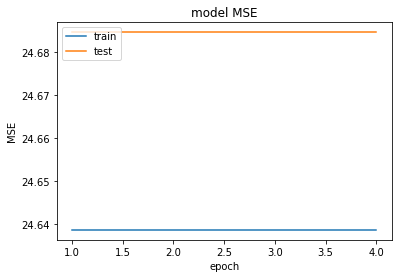

DNN3 Adam-0.01-4-epoch


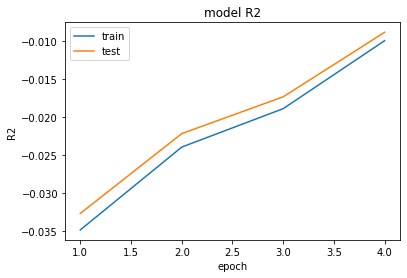

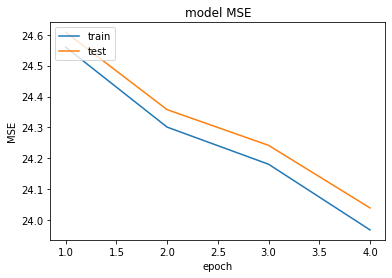

DNN3 Adam-0.001-4-epoch


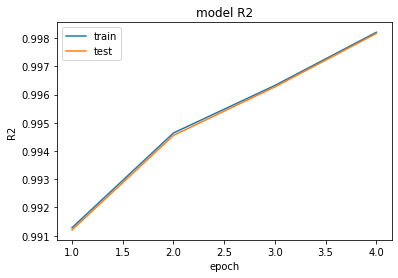

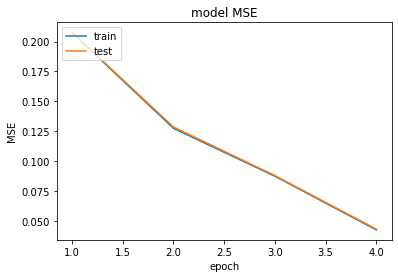

In [18]:
for combination in result_histories:
    print("\033[1m\033[91m" + combination + "\033[0m")
    plot_learning_curves(result_histories[combination], baseline)

# Висновок

Під час виконання даної домашньої роботи були реалізовані та натреновані різні комбінації DNN, оптимізаторів та коефіцієнтів швидкості навчання. 

Серед отриманих комбінацій можна виділити 5 найкращих: 
*   DNN1, optimizer SGD, learning rate 0.001
*   DNN2, optimizer SGD, learning rate 0.001
*   DNN2, optimizer ADAM, learning rate 0.001
*   DNN2, optimizer RMS, learning rate 0.001
*   DNN3, optimizer ADAM, learning rate 0.001

З натренованих моделей точність вищу за 70% показали 9 комбінацій. Тепер оцінимо вплив окремо DNN, оптимізаторів та коефіцієнтів швидкості навчання. Серед добре натренованих комбінацій є всі три типи DNN, більшість моделей використовували оптимізатор Adam або SGD, а майже усі комбінації з learning_rate = 0.1 не змогли досягти точності 70%. 

Лінійна регресія показує точність 75%, що є непоганим результатом, але гіршим, ніж більшість натренованих моделей.